# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
#from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

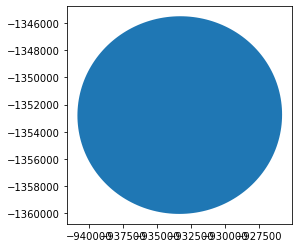

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

**Load full time-series of SST (Sea Surface Temperature), for the Lord Howe Marine Park area, from 2002 to 2018. It tooks 5 hours. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:15:31.427113 to finish


In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

**Mask the nodata (-999) as 'nan'**

In [7]:
data = mask_invalid_data(data)

In [9]:
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [8]:
# note the time dimension: 6214
data.dims


Frozen(SortedKeysDict({'time': 6214, 'y': 13, 'x': 12}))

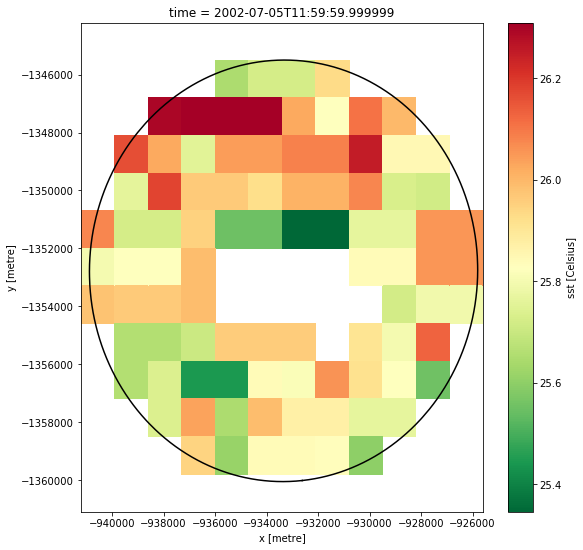

In [10]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

**testDF contains all SST data loaded: 3600 (90 x 40) locations (as columns) with 5900 daily time-series (as rows)**

In [11]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.y.size:
    while lonIndex < data.x.size:
        lat = data.sst[:,latIndex,lonIndex].y.values
        lon = data.sst[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

In [12]:
latlonDF.head(10)

,lat,lon
id,,
1,-1344850.0,-940550.0
2,-1344850.0,-939250.0
3,-1344850.0,-937950.0
4,-1344850.0,-936650.0
5,-1344850.0,-935350.0
6,-1344850.0,-934050.0
7,-1344850.0,-932750.0
8,-1344850.0,-931450.0
9,-1344850.0,-930150.0


In [14]:
testDF.tail(10)

,1,2,3,4,5,6,7,8,9,10,...,147,148,149,150,151,152,153,154,155,156
date,,,,,,,,,,,,,,,,,,,,,
20190713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**The pad function interpolate over missing data in a time series. Courtesy of Hobday's marine heat waves codes**

In [15]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [16]:
testDF1 = testDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame. 
Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years**

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
i = 0
dayofyears = []

while i < testDF1.index.size:
    date = testDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    print(date)
    print(dayofyear)

    dayofyears.append(dayofyear)

    i = i + 1
testDF1['dayofyear']=dayofyears



20020704
185
20020705
186
20020706
187
20020707
188
20020708
189
20020709
190
20020710
191
20020711
192
20020712
193
20020713
194
20020714
195
20020715
196
20020716
197
20020717
198
20020718
199
20020719
200
20020720
201
20020721
202
20020722
203
20020723
204
20020724
205
20020725
206
20020726
207
20020727
208
20020728
209
20020729
210
20020807
219
20020808
220
20020809
221
20020810
222
20020811
223
20020812
224
20020813
225
20020814
226
20020815
227
20020816
228
20020817
229
20020818
230
20020819
231
20020820
232
20020821
233
20020822
234
20020823
235
20020824
236
20020825
237
20020826
238
20020827
239
20020828
240
20020829
241
20020830
242
20020831
243
20020901
244
20020902
245
20020903
246
20020904
247
20020905
248
20020906
249
20020907
250
20020908
251
20020909
252
20020910
253
20020911
254
20020912
255
20020913
256
20020914
257
20020915
258
20020916
259
20020917
260
20020918
261
20020919
262
20020920
263
20020921
264
20020922
265
20020923
266
20020924
267
20020925
268
20020926
269

20040820
232
20040821
233
20040822
234
20040823
235
20040824
236
20040825
237
20040826
238
20040827
239
20040828
240
20040829
241
20040830
242
20040831
243
20040901
244
20040902
245
20040903
246
20040904
247
20040905
248
20040906
249
20040907
250
20040908
251
20040909
252
20040910
253
20040911
254
20040912
255
20040913
256
20040914
257
20040915
258
20040916
259
20040917
260
20040918
261
20040919
262
20040920
263
20040921
264
20040922
265
20040923
266
20040924
267
20040925
268
20040926
269
20040927
270
20040928
271
20040929
272
20040930
273
20041001
274
20041002
275
20041003
276
20041004
277
20041005
278
20041006
279
20041007
280
20041008
281
20041009
282
20041010
283
20041011
284
20041012
285
20041013
286
20041014
287
20041015
288
20041016
289
20041017
290
20041018
291
20041019
292
20041020
293
20041021
294
20041022
295
20041023
296
20041024
297
20041025
298
20041026
299
20041027
300
20041028
301
20041029
302
20041030
303
20041031
304
20041101
305
20041102
306
20041103
307
20041104
308

168
20060618
169
20060619
170
20060620
171
20060621
172
20060622
173
20060623
174
20060624
175
20060625
176
20060626
177
20060627
178
20060628
179
20060629
180
20060630
181
20060701
182
20060702
183
20060703
184
20060704
185
20060706
187
20060707
188
20060708
189
20060709
190
20060710
191
20060711
192
20060712
193
20060713
194
20060714
195
20060715
196
20060716
197
20060717
198
20060718
199
20060719
200
20060720
201
20060721
202
20060722
203
20060723
204
20060724
205
20060725
206
20060726
207
20060727
208
20060728
209
20060729
210
20060730
211
20060731
212
20060801
213
20060802
214
20060803
215
20060804
216
20060805
217
20060806
218
20060807
219
20060808
220
20060809
221
20060810
222
20060811
223
20060812
224
20060813
225
20060814
226
20060815
227
20060816
228
20060817
229
20060818
230
20060819
231
20060820
232
20060821
233
20060822
234
20060823
235
20060824
236
20060825
237
20060826
238
20060827
239
20060828
240
20060829
241
20060830
242
20060831
243
20060901
244
20060902
245
20060903

191
20080711
192
20080712
193
20080713
194
20080714
195
20080715
196
20080716
197
20080717
198
20080718
199
20080719
200
20080720
201
20080721
202
20080722
203
20080723
204
20080724
205
20080725
206
20080726
207
20080727
208
20080728
209
20080729
210
20080730
211
20080731
212
20080801
213
20080802
214
20080803
215
20080804
216
20080805
217
20080806
218
20080807
219
20080808
220
20080809
221
20080810
222
20080811
223
20080812
224
20080813
225
20080814
226
20080815
227
20080816
228
20080817
229
20080818
230
20080819
231
20080820
232
20080821
233
20080822
234
20080823
235
20080824
236
20080825
237
20080826
238
20080827
239
20080828
240
20080829
241
20080830
242
20080831
243
20080901
244
20080902
245
20080903
246
20080904
247
20080905
248
20080906
249
20080907
250
20080908
251
20080909
252
20080910
253
20080911
254
20080912
255
20080913
256
20080914
257
20080915
258
20080916
259
20080917
260
20080918
261
20080919
262
20080920
263
20080921
264
20080922
265
20080923
266
20080924
267
20080925

20100731
212
20100801
213
20100802
214
20100803
215
20100804
216
20100805
217
20100806
218
20100807
219
20100808
220
20100809
221
20100810
222
20100811
223
20100812
224
20100813
225
20100814
226
20100815
227
20100816
228
20100817
229
20100818
230
20100819
231
20100820
232
20100821
233
20100822
234
20100823
235
20100824
236
20100825
237
20100826
238
20100827
239
20100828
240
20100829
241
20100830
242
20100831
243
20100901
244
20100902
245
20100903
246
20100904
247
20100905
248
20100906
249
20100907
250
20100908
251
20100909
252
20100910
253
20100911
254
20100912
255
20100913
256
20100914
257
20100915
258
20100916
259
20100917
260
20100918
261
20100919
262
20100920
263
20100921
264
20100922
265
20100923
266
20100924
267
20100925
268
20100926
269
20100927
270
20100928
271
20100929
272
20100930
273
20101001
274
20101002
275
20101003
276
20101004
277
20101005
278
20101006
279
20101007
280
20101008
281
20101009
282
20101010
283
20101011
284
20101012
285
20101013
286
20101014
287
20101015
288

20120820
232
20120821
233
20120822
234
20120823
235
20120824
236
20120825
237
20120826
238
20120827
239
20120828
240
20120829
241
20120830
242
20120831
243
20120901
244
20120902
245
20120903
246
20120904
247
20120905
248
20120906
249
20120907
250
20120908
251
20120909
252
20120910
253
20120911
254
20120912
255
20120913
256
20120914
257
20120915
258
20120916
259
20120917
260
20120918
261
20120919
262
20120920
263
20120921
264
20120922
265
20120923
266
20120924
267
20120925
268
20120926
269
20120927
270
20120928
271
20120929
272
20120930
273
20121001
274
20121002
275
20121003
276
20121004
277
20121005
278
20121006
279
20121007
280
20121008
281
20121009
282
20121010
283
20121011
284
20121012
285
20121013
286
20121014
287
20121015
288
20121016
289
20121017
290
20121018
291
20121019
292
20121020
293
20121021
294
20121022
295
20121023
296
20121024
297
20121025
298
20121026
299
20121027
300
20121028
301
20121029
302
20121030
303
20121031
304
20121101
305
20121102
306
20121103
307
20121104
308

251
20140909
252
20140910
253
20140911
254
20140912
255
20140913
256
20140914
257
20140915
258
20140916
259
20140917
260
20140918
261
20140919
262
20140920
263
20140921
264
20140922
265
20140923
266
20140924
267
20140925
268
20140926
269
20140927
270
20140928
271
20140929
272
20140930
273
20141001
274
20141002
275
20141003
276
20141004
277
20141005
278
20141006
279
20141007
280
20141008
281
20141009
282
20141010
283
20141011
284
20141012
285
20141013
286
20141014
287
20141015
288
20141016
289
20141017
290
20141018
291
20141019
292
20141020
293
20141021
294
20141022
295
20141023
296
20141024
297
20141025
298
20141026
299
20141027
300
20141028
301
20141029
302
20141030
303
20141031
304
20141101
305
20141102
306
20141103
307
20141104
308
20141105
309
20141106
310
20141107
311
20141108
312
20141109
313
20141110
314
20141111
315
20141112
316
20141113
317
20141114
318
20141115
319
20141116
320
20141117
321
20141118
322
20141119
323
20141120
324
20141121
325
20141122
326
20141123
327
20141124

20160816
228
20160817
229
20160818
230
20160819
231
20160820
232
20160821
233
20160822
234
20160823
235
20160824
236
20160825
237
20160826
238
20160827
239
20160828
240
20160829
241
20160830
242
20160831
243
20160901
244
20160902
245
20160903
246
20160904
247
20160905
248
20160906
249
20160907
250
20160908
251
20160909
252
20160910
253
20160911
254
20160912
255
20160913
256
20160914
257
20160915
258
20160916
259
20160917
260
20160918
261
20160919
262
20160920
263
20160921
264
20160922
265
20160923
266
20160924
267
20160925
268
20160926
269
20160927
270
20160928
271
20160929
272
20160930
273
20161001
274
20161002
275
20161003
276
20161004
277
20161005
278
20161006
279
20161007
280
20161008
281
20161009
282
20161010
283
20161011
284
20161012
285
20161013
286
20161014
287
20161015
288
20161016
289
20161017
290
20161018
291
20161019
292
20161020
293
20161021
294
20161022
295
20161023
296
20161024
297
20161025
298
20161026
299
20161027
300
20161028
301
20161029
302
20161030
303
20161031
304

In [18]:
testDF1.shape

(6210, 157)

**The testIDF1 is generated from testDF1 after applying the interpolation (pad) function**

In [19]:
testIDF1 = pd.DataFrame()
interpolatedSSTList = []

for i in testDF1.columns:
    sst = testDF1[i].values
    if np.isnan(sst).all():
        print(i, 'no data')
        latlonDF = latlonDF.drop(i, axis=0)
    else:
        interpolatedSST = pad(sst,maxPadLength=2)
        testIDF1[i] = interpolatedSST
    
testIDF1['date'] = testDF1.index
testIDF1['dayofyear'] = testDF1['dayofyear'].values
testIDF1.set_index('date', inplace=True)

1 no data
2 no data
3 no data
4 no data
5 no data
6 no data
7 no data
8 no data
9 no data
10 no data
11 no data
12 no data
13 no data
14 no data
15 no data
16 no data
21 no data
22 no data
23 no data
24 no data
25 no data
26 no data
35 no data
36 no data
37 no data
48 no data
49 no data
60 no data
97 no data
108 no data
109 no data
120 no data
121 no data
122 no data
131 no data
132 no data
133 no data
134 no data
135 no data
142 no data
143 no data
144 no data
145 no data
146 no data
147 no data
148 no data
149 no data
150 no data
151 no data
152 no data
153 no data
154 no data
155 no data
156 no data


In [20]:
testIDF1.shape

(6210, 103)

In [21]:
x = testIDF1.loc['20020704']
# counting the number of nan in x
np.count_nonzero(np.isnan(x))

2

**The 90 percentile is used as the threshold to identify the MHWs.
The SST values of the same dayofyear are grouped. The 90 percentile is then calculated for each group**

In [22]:
# 90th percentile from testIDF1
nintyDF = pd.DataFrame()

i = 1
while i < 3601:
    print(str(i))
    sst_series_g = testIDF1[i].groupby(testIDF1['dayofyear'])
    sst_90 = sst_series_g.transform(nintypercentile)
    nintyDF[i] = sst_90
    i += 1
nintyDF['date'] = testDF1.index
nintyDF['dayofyear'] = testDF1['dayofyear'].values
nintyDF.set_index('date', inplace=True)

1


KeyError: 1

**Another way of calculating the 90 perentile threshold. This time uses a 11-days window so that 
we have a much larger number of SST values each date from which to calculate the 90 percentile.
This also smoothes the 90 percentile climatology to a large degree.**

In [23]:
# 90th percentile with 11-days window
# this one takes too long to complete
nintyDF1 = pd.DataFrame()
i = 1

while i < 3601:
    print(str(i))
    nintyList = []
    for date in testIDF1.index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF1[i] = nintyList
    i += 1
nintyDF1['date'] = testDF1.index
nintyDF1['dayofyear'] = testDF1['dayofyear'].values
nintyDF1.set_index('date', inplace=True)

1


KeyError: 1

**More efficient codes to calculate the 90 percentile climatology data with 11-days window are shown 
in the next few cells**

In [25]:
# 90th percentile with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
nintyDF2 = pd.DataFrame()

print('start', datetime.now())
for i in testIDF1.columns:
    print(str(i))
    nintyList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF2[i] = nintyList
   
#nintyDF2['date'] = testDF1.index
nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)
print('end', datetime.now())

start 2019-11-06 15:35:44.331386
17
18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
dayofyear
end 2019-11-06 15:37:14.499962


In [26]:
nintyDF3 = testIDF1.copy(deep=True)

In [27]:
print('start', datetime.now())
for date in nintyDF3.index:
    print(date)
    dayofyear = nintyDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    
print('end', datetime.now())

start 2019-11-06 15:37:26.780750
20020704
185
20020705
186.0
20020706
187.0


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20020818
230.0
20020819
231.0
20020820
232.0
20020821
233.0
20020822
234.0
20020823
235.0
20020824
236.0
20020825
237.0
20020826
238.0
20020827
239.0
20020828
240.0
20020829
241.0
20020830
242.0
20020831
243.0
20020901
244.0
20020902
245.0
20020903
246.0
20020904
247.0
20020905
248.0
20020906
249.0
20020907
250.0
20020908
251.0
20020909
252.0
20020910
253.0
20020911
254.0
20020912
255.0
20020913
256.0
20020914
257.0
20020915
258.0
20020916
259.0
20020917
260.0
20020918
261.0
20020919
2

20040124
24.0
20040125
25.0
20040126
26.0
20040127
27.0
20040128
28.0
20040129
29.0
20040130
30.0
20040131
31.0
20040201
32.0
20040202
33.0
20040203
34.0
20040204
35.0
20040205
36.0
20040206
37.0
20040207
38.0
20040208
39.0
20040209
40.0
20040210
41.0
20040211
42.0
20040212
43.0
20040213
44.0
20040214
45.0
20040215
46.0
20040216
47.0
20040217
48.0
20040218
49.0
20040219
50.0
20040220
51.0
20040221
52.0
20040222
53.0
20040223
54.0
20040224
55.0
20040225
56.0
20040226
57.0
20040227
58.0
20040228
59.0
20040301
60.0
20040302
61.0
20040303
62.0
20040304
63.0
20040305
64.0
20040306
65.0
20040307
66.0
20040308
67.0
20040309
68.0
20040310
69.0
20040311
70.0
20040312
71.0
20040313
72.0
20040314
73.0
20040315
74.0
20040316
75.0
20040317
76.0
20040318
77.0
20040319
78.0
20040320
79.0
20040321
80.0
20040322
81.0
20040323
82.0
20040324
83.0
20040325
84.0
20040326
85.0
20040327
86.0
20040328
87.0
20040329
88.0
20040330
89.0
20040331
90.0
20040401
91.0
20040402
92.0
20040403
93.0
20040404
94.0
200404

20050807
219.0
20050808
220.0
20050809
221.0
20050810
222.0
20050811
223.0
20050812
224.0
20050813
225.0
20050814
226.0
20050815
227.0
20050816
228.0
20050817
229.0
20050818
230.0
20050819
231.0
20050820
232.0
20050821
233.0
20050822
234.0
20050823
235.0
20050824
236.0
20050825
237.0
20050826
238.0
20050827
239.0
20050828
240.0
20050829
241.0
20050830
242.0
20050831
243.0
20050901
244.0
20050902
245.0
20050903
246.0
20050904
247.0
20050905
248.0
20050906
249.0
20050907
250.0
20050908
251.0
20050909
252.0
20050910
253.0
20050911
254.0
20050912
255.0
20050913
256.0
20050914
257.0
20050915
258.0
20050916
259.0
20050917
260.0
20050918
261.0
20050919
262.0
20050920
263.0
20050921
264.0
20050922
265.0
20050923
266.0
20050924
267.0
20050925
268.0
20050926
269.0
20050927
270.0
20050928
271.0
20050929
272.0
20050930
273.0
20051001
274.0
20051002
275.0
20051003
276.0
20051004
277.0
20051005
278.0
20051006
279.0
20051007
280.0
20051008
281.0
20051009
282.0
20051010
283.0
20051011
284.0
20051012
2

20070223
54.0
20070224
55.0
20070225
56.0
20070226
57.0
20070227
58.0
20070228
59.0
20070301
60.0
20070302
61.0
20070303
62.0
20070304
63.0
20070305
64.0
20070306
65.0
20070307
66.0
20070308
67.0
20070309
68.0
20070310
69.0
20070311
70.0
20070312
71.0
20070313
72.0
20070314
73.0
20070315
74.0
20070316
75.0
20070317
76.0
20070318
77.0
20070319
78.0
20070320
79.0
20070321
80.0
20070322
81.0
20070323
82.0
20070324
83.0
20070325
84.0
20070326
85.0
20070327
86.0
20070328
87.0
20070329
88.0
20070330
89.0
20070331
90.0
20070401
91.0
20070402
92.0
20070403
93.0
20070404
94.0
20070405
95.0
20070406
96.0
20070407
97.0
20070408
98.0
20070409
99.0
20070410
100.0
20070411
101.0
20070412
102.0
20070413
103.0
20070414
104.0
20070415
105.0
20070416
106.0
20070417
107.0
20070418
108.0
20070419
109.0
20070420
110.0
20070421
111.0
20070422
112.0
20070423
113.0
20070424
114.0
20070425
115.0
20070426
116.0
20070427
117.0
20070428
118.0
20070429
119.0
20070430
120.0
20070501
121.0
20070502
122.0
20070503
12

20080907
250.0
20080908
251.0
20080909
252.0
20080910
253.0
20080911
254.0
20080912
255.0
20080913
256.0
20080914
257.0
20080915
258.0
20080916
259.0
20080917
260.0
20080918
261.0
20080919
262.0
20080920
263.0
20080921
264.0
20080922
265.0
20080923
266.0
20080924
267.0
20080925
268.0
20080926
269.0
20080927
270.0
20080928
271.0
20080929
272.0
20080930
273.0
20081001
274.0
20081002
275.0
20081003
276.0
20081004
277.0
20081005
278.0
20081006
279.0
20081007
280.0
20081008
281.0
20081009
282.0
20081010
283.0
20081011
284.0
20081012
285.0
20081013
286.0
20081014
287.0
20081015
288.0
20081016
289.0
20081017
290.0
20081018
291.0
20081019
292.0
20081020
293.0
20081021
294.0
20081022
295.0
20081023
296.0
20081024
297.0
20081025
298.0
20081026
299.0
20081027
300.0
20081028
301.0
20081029
302.0
20081030
303.0
20081031
304.0
20081101
305.0
20081102
306.0
20081103
307.0
20081104
308.0
20081105
309.0
20081106
310.0
20081107
311.0
20081108
312.0
20081109
313.0
20081110
314.0
20081111
315.0
20081112
3

20100322
81.0
20100323
82.0
20100324
83.0
20100325
84.0
20100326
85.0
20100327
86.0
20100328
87.0
20100329
88.0
20100330
89.0
20100331
90.0
20100401
91.0
20100402
92.0
20100403
93.0
20100404
94.0
20100405
95.0
20100406
96.0
20100407
97.0
20100408
98.0
20100409
99.0
20100410
100.0
20100411
101.0
20100412
102.0
20100413
103.0
20100414
104.0
20100415
105.0
20100416
106.0
20100417
107.0
20100418
108.0
20100419
109.0
20100420
110.0
20100421
111.0
20100422
112.0
20100423
113.0
20100424
114.0
20100425
115.0
20100426
116.0
20100427
117.0
20100428
118.0
20100429
119.0
20100430
120.0
20100501
121.0
20100502
122.0
20100503
123.0
20100504
124.0
20100505
125.0
20100506
126.0
20100507
127.0
20100508
128.0
20100509
129.0
20100510
130.0
20100511
131.0
20100512
132.0
20100513
133.0
20100514
134.0
20100515
135.0
20100516
136.0
20100517
137.0
20100518
138.0
20100519
139.0
20100520
140.0
20100521
141.0
20100522
142.0
20100523
143.0
20100524
144.0
20100525
145.0
20100526
146.0
20100527
147.0
20100528
148.0

20111001
274.0
20111002
275.0
20111003
276.0
20111004
277.0
20111005
278.0
20111006
279.0
20111007
280.0
20111008
281.0
20111009
282.0
20111010
283.0
20111011
284.0
20111012
285.0
20111013
286.0
20111014
287.0
20111015
288.0
20111016
289.0
20111017
290.0
20111018
291.0
20111019
292.0
20111020
293.0
20111021
294.0
20111022
295.0
20111023
296.0
20111024
297.0
20111025
298.0
20111026
299.0
20111027
300.0
20111028
301.0
20111029
302.0
20111030
303.0
20111031
304.0
20111101
305.0
20111102
306.0
20111103
307.0
20111104
308.0
20111105
309.0
20111106
310.0
20111107
311.0
20111108
312.0
20111109
313.0
20111110
314.0
20111111
315.0
20111112
316.0
20111113
317.0
20111114
318.0
20111115
319.0
20111116
320.0
20111117
321.0
20111118
322.0
20111119
323.0
20111120
324.0
20111121
325.0
20111122
326.0
20111123
327.0
20111124
328.0
20111125
329.0
20111126
330.0
20111127
331.0
20111128
332.0
20111129
333.0
20111130
334.0
20111201
335.0
20111202
336.0
20111203
337.0
20111204
338.0
20111205
339.0
20111206
3

20130415
105.0
20130416
106.0
20130417
107.0
20130418
108.0
20130419
109.0
20130420
110.0
20130421
111.0
20130422
112.0
20130423
113.0
20130424
114.0
20130425
115.0
20130426
116.0
20130427
117.0
20130428
118.0
20130429
119.0
20130430
120.0
20130501
121.0
20130502
122.0
20130503
123.0
20130504
124.0
20130505
125.0
20130506
126.0
20130507
127.0
20130508
128.0
20130509
129.0
20130510
130.0
20130511
131.0
20130512
132.0
20130513
133.0
20130514
134.0
20130515
135.0
20130516
136.0
20130517
137.0
20130518
138.0
20130519
139.0
20130520
140.0
20130521
141.0
20130522
142.0
20130523
143.0
20130524
144.0
20130525
145.0
20130526
146.0
20130527
147.0
20130528
148.0
20130529
149.0
20130530
150.0
20130531
151.0
20130601
152.0
20130602
153.0
20130603
154.0
20130604
155.0
20130605
156.0
20130606
157.0
20130607
158.0
20130608
159.0
20130609
160.0
20130610
161.0
20130611
162.0
20130612
163.0
20130613
164.0
20130614
165.0
20130615
166.0
20130616
167.0
20130617
168.0
20130618
169.0
20130619
170.0
20130620
1

20141024
297.0
20141025
298.0
20141026
299.0
20141027
300.0
20141028
301.0
20141029
302.0
20141030
303.0
20141031
304.0
20141101
305.0
20141102
306.0
20141103
307.0
20141104
308.0
20141105
309.0
20141106
310.0
20141107
311.0
20141108
312.0
20141109
313.0
20141110
314.0
20141111
315.0
20141112
316.0
20141113
317.0
20141114
318.0
20141115
319.0
20141116
320.0
20141117
321.0
20141118
322.0
20141119
323.0
20141120
324.0
20141121
325.0
20141122
326.0
20141123
327.0
20141124
328.0
20141125
329.0
20141126
330.0
20141127
331.0
20141128
332.0
20141129
333.0
20141130
334.0
20141201
335.0
20141202
336.0
20141203
337.0
20141204
338.0
20141205
339.0
20141206
340.0
20141207
341.0
20141208
342.0
20141209
343.0
20141210
344.0
20141211
345.0
20141212
346.0
20141213
347.0
20141214
348.0
20141215
349.0
20141216
350.0
20141217
351.0
20141218
352.0
20141219
353.0
20141220
354.0
20141221
355.0
20141222
356.0
20141223
357.0
20141224
358.0
20141225
359.0
20141226
360.0
20141227
361.0
20141228
362.0
20141229
3

20160512
132.0
20160513
133.0
20160514
134.0
20160515
135.0
20160516
136.0
20160517
137.0
20160518
138.0
20160519
139.0
20160520
140.0
20160521
141.0
20160522
142.0
20160523
143.0
20160524
144.0
20160525
145.0
20160526
146.0
20160527
147.0
20160528
148.0
20160529
149.0
20160530
150.0
20160531
151.0
20160601
152.0
20160602
153.0
20160603
154.0
20160604
155.0
20160605
156.0
20160606
157.0
20160607
158.0
20160608
159.0
20160609
160.0
20160610
161.0
20160611
162.0
20160612
163.0
20160613
164.0
20160614
165.0
20160615
166.0
20160616
167.0
20160617
168.0
20160618
169.0
20160619
170.0
20160620
171.0
20160621
172.0
20160622
173.0
20160623
174.0
20160624
175.0
20160625
176.0
20160626
177.0
20160627
178.0
20160628
179.0
20160629
180.0
20160630
181.0
20160701
182.0
20160702
183.0
20160703
184.0
20160704
185.0
20160705
186.0
20160706
187.0
20160707
188.0
20160708
189.0
20160709
190.0
20160710
191.0
20160711
192.0
20160712
193.0
20160713
194.0
20160714
195.0
20160715
196.0
20160716
197.0
20160717
1

20171120
324.0
20171121
325.0
20171122
326.0
20171123
327.0
20171124
328.0
20171125
329.0
20171126
330.0
20171127
331.0
20171128
332.0
20171129
333.0
20171130
334.0
20171201
335.0
20171202
336.0
20171203
337.0
20171204
338.0
20171205
339.0
20171206
340.0
20171207
341.0
20171208
342.0
20171209
343.0
20171210
344.0
20171211
345.0
20171212
346.0
20171213
347.0
20171214
348.0
20171215
349.0
20171216
350.0
20171217
351.0
20171218
352.0
20171219
353.0
20171220
354.0
20171221
355.0
20171222
356.0
20171223
357.0
20171224
358.0
20171225
359.0
20171226
360.0
20171227
361.0
20171228
362.0
20171229
363.0
20171230
364.0
20171231
365.0
20180101
1.0
20180102
2.0
20180103
3.0
20180104
4.0
20180105
5.0
20180106
6.0
20180107
7.0
20180108
8.0
20180109
9.0
20180110
10.0
20180111
11.0
20180112
12.0
20180113
13.0
20180114
14.0
20180115
15.0
20180116
16.0
20180117
17.0
20180118
18.0
20180119
19.0
20180120
20.0
20180121
21.0
20180122
22.0
20180123
23.0
20180124
24.0
20180125
25.0
20180126
26.0
20180127
27.0
2

20190606
157.0
20190607
158.0
20190608
159.0
20190609
160.0
20190610
161.0
20190611
162.0
20190612
163.0
20190613
164.0
20190614
165.0
20190615
166.0
20190616
167.0
20190617
168.0
20190618
169.0
20190619
170.0
20190620
171.0
20190621
172.0
20190622
173.0
20190623
174.0
20190624
175.0
20190625
176.0
20190626
177.0
20190627
178.0
20190628
179.0
20190629
180.0
20190630
181.0
20190701
182.0
20190702
183.0
20190703
184.0
20190704
185.0
20190705
186.0
20190706
187.0
20190707
188.0
20190708
189.0
20190709
190.0
20190710
191.0
20190711
192.0
20190712
193.0
20190713
194.0
20190714
195.0
20190715
196.0
20190716
197.0
20190717
198.0
20190718
199.0
20190719
200.0
20190720
201.0
20190721
202.0
20190722
203.0
end 2019-11-06 15:42:01.023988


**We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

In [28]:
nintyDF4 = nintyDF3.copy(deep=True)

In [29]:
nintyDF4 = nintyDF4.rolling(31,center=True).mean()

In [30]:
nintyDF4['dayofyear'] = nintyDF3.dayofyear

**Calculate the SST anomalies (differences) between the SST values and the 90 percentile data**

In [31]:
print('start', datetime.now())
diffDF4 = pd.DataFrame()


for i in testIDF1.columns:
    if i == 'dayofyear':
        print(i)
    else:
        
        diff = testIDF1[i] - nintyDF4[i]
        diffDF4[i] = diff
   
diffDF4['date'] = testDF1.index
diffDF4.set_index('date', inplace=True)
print('end', datetime.now())

start 2019-11-06 15:44:21.950996
dayofyear
end 2019-11-06 15:44:22.191477


In [32]:
testIDF1.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,26.920000,27.030001,26.940001,26.945000,26.930000,26.825001,26.825001,26.825001,26.940001,26.844999,...,26.700001,26.830000,26.830000,27.145000,27.145000,26.700001,26.700001,26.705000,26.705000,185
20020705,25.650000,25.725000,25.725000,25.930000,26.295000,26.309999,26.309999,26.309999,26.025000,25.825001,...,25.875000,25.764999,25.764999,25.945000,25.615000,25.840000,25.840000,25.834999,25.600000,186
20020706,26.825001,26.570000,26.764999,26.620001,26.915001,26.795000,26.795000,26.885000,26.690001,26.780001,...,26.520000,26.639999,26.645000,26.580000,26.580000,26.465000,26.379999,26.520000,26.504999,187
20020707,26.540001,26.465000,26.512501,26.420000,26.602501,26.685001,26.564999,26.627501,26.597500,26.600000,...,26.492500,26.485001,26.442501,26.330000,26.452499,26.462500,26.320000,26.447500,26.337500,188
20020708,26.254999,26.360001,26.260000,26.219999,26.290001,26.575001,26.334999,26.370001,26.504999,26.420000,...,26.465000,26.330000,26.240000,26.080000,26.325001,26.459999,26.260000,26.375000,26.170000,189
20020709,26.250000,26.302502,26.307499,26.240000,26.232500,26.375000,26.459999,26.435001,26.439999,26.415001,...,26.545000,26.337500,26.389999,26.244999,26.367500,26.439999,26.285000,26.244999,26.227501,190
20020710,26.245001,26.245001,26.355000,26.260000,26.174999,26.174999,26.584999,26.500000,26.375000,26.410000,...,26.625000,26.344999,26.540001,26.410000,26.410000,26.420000,26.309999,26.115000,26.285000,191
20020711,26.340000,26.035000,26.355000,26.410000,26.365000,26.400000,26.180000,26.355000,26.355000,26.410000,...,26.445000,26.219999,26.424999,26.280001,26.280001,26.485001,26.565001,26.445000,26.379999,192
20020712,26.110001,26.299999,26.275000,26.299999,26.330000,25.940001,25.940001,26.379999,26.379999,26.299999,...,26.125000,26.155001,26.155001,25.940001,26.230000,26.365000,26.420000,26.254999,26.440001,193


In [33]:
nintyDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.0
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.0
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.0
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0


In [34]:
diffDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**plot the two 90 percentile dataset together. One is from 11-days window; the other illustrates further 
smooth using 31-days running average.**

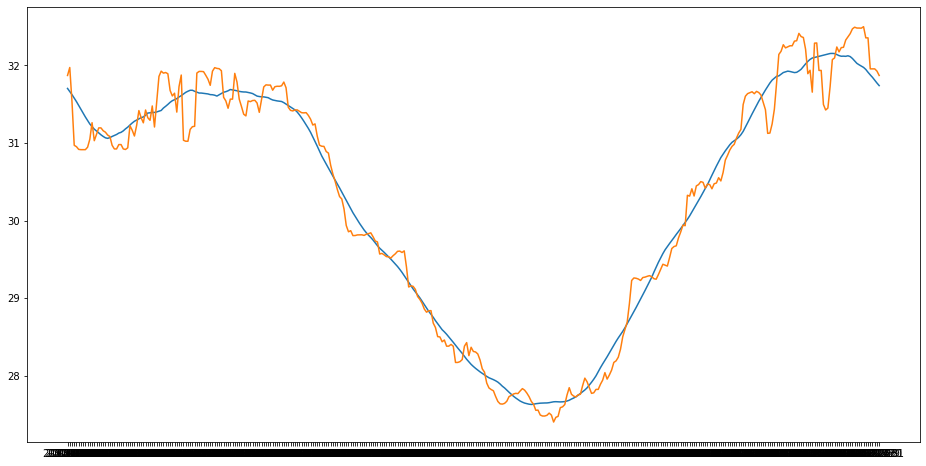

In [35]:
fig = plt.figure(figsize=(16,8))
plt.plot(nintyDF4.loc['20120101':'20121231'][17])
plt.plot(nintyDF3.loc['20120101':'20121231'][17])

**The main function to identify the MHW events and generate statistics. Return two dataframes. 
One contains the summary statistics. The other contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The function also saves individual MHW files and the summary statistics file.** 

In [36]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis(sstDiff_data,lonlatDF,amp,outDir):
    
    print(datetime.now())
   
    
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    #mhwEList = []
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    


   
    # loop through each Point
    for id in sstDiff_data.columns:
        print(str(id))
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        # label events: positive value(s)
       
        events, n_events = label(point1V_1)
        #print(events)
        #print(n_events)
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:

                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []

        onset_rate = []
        decline_rate = []
        i = 0
      
        while i < mhwE.index.size:
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:

                        sst_diff = point1V[j]
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
            #print('event', i, ':', intensity_values)
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5


            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)
        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                statsDF.loc[date_start:date_end,str(id)] = sstDiff_data.loc[date_start:date_end][id].values
         

    #   geneate the summary characteristics of the MHWs    
    #    mhwEList.append(mhwE)
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    #mhwDF1['MHWs'] = mhwEList
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    print(datetime.now())
    return mhwDF1, statsDF


**Apply the main function**

In [37]:
outdir = '/home/547/zxh547/dea-notebooks/CI'
amp = 'CI'
mhwDF4, statsDF4 = do_analysis(diffDF4,latlonDF,amp,outdir)

2019-11-06 15:46:02.500958
17


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
2019-11-06 15:46:17.460048


In [38]:
mhwDF4.shape

(102, 19)

In [39]:
mhwDF4.tail(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
92,127,-1357850.0,-932750.0,8,60,42.097484,0.701625,2.383267,540,16,16,540,1.095251,1.095251,540,16,17.524017,540,16
93,128,-1357850.0,-931450.0,11,90,54.318762,0.603542,2.407111,540,17,17,540,1.169179,1.169179,540,17,19.876036,540,17
94,129,-1357850.0,-930150.0,8,74,50.948271,0.688490,2.597734,540,17,18,509,0.758007,1.091379,540,17,18.553445,540,17
95,130,-1357850.0,-928850.0,9,75,49.894118,0.665255,2.639081,541,16,18,509,0.681803,1.049999,-692,5,15.356193,541,16
96,136,-1359150.0,-936650.0,10,81,49.744058,0.614124,2.388162,533,13,13,533,0.658132,0.983395,517,10,9.833952,517,10
97,137,-1359150.0,-935350.0,9,80,52.206073,0.652576,2.322961,539,18,18,509,0.766754,1.119078,539,18,20.143407,539,18
98,138,-1359150.0,-934050.0,12,94,58.525000,0.622606,2.439981,-1985,6,18,509,0.686228,0.998302,1195,5,13.897694,540,16
99,139,-1359150.0,-932750.0,10,83,50.071752,0.603274,2.241817,541,15,16,511,0.709671,0.905792,541,15,13.586879,541,15
100,140,-1359150.0,-931450.0,8,64,37.034685,0.578667,1.654121,546,11,18,509,0.696483,0.985487,546,11,12.536686,509,18
101,141,-1359150.0,-930150.0,10,65,38.152541,0.586962,1.807662,546,11,11,546,1.006353,1.006971,520,7,11.069879,546,11


In [40]:
statsDF4.shape

(6210, 100)

In [41]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
x = statsDF4.loc['20061202']
print(np.count_nonzero(~np.isnan(x)))
x = testIDF1.loc['20061202']
# counting the number of not nan in x
print(np.count_nonzero(~np.isnan(x)))

0
26


**Calculate summary statistics for the second dataframe**

In [43]:
minList = []
maxList = []
meanList = []
stdList = []
countList = []
observedList = []
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
    x = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(x))
    observedList.append(observed)
statsDF4['min'] = minList
statsDF4['max'] = maxList
statsDF4['mean'] = meanList
statsDF4['std'] = stdList
statsDF4['count'] = countList
statsDF4['observed'] = observedList

    

In [44]:
print(statsDF4.shape)
print(testIDF1.shape)


(6210, 106)
(6210, 103)


In [47]:
statsDF4.tail(50)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20190603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8
20190604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
20190605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,73
20190606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,73
20190607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,96
20190608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103


In [46]:
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20160601':'20160831',col1:col2].values
y=statsDF4.loc['20160601':'20160831','count'].values
print(x[x>=0].size)
z = statsDF4.loc['20160601':'20160831','observed'].values
k = z[y>0]
print(y.sum())
print(k.sum())

17 141
3338
3338
6255


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


**Generate seasonal statistics**

In [49]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
observed1List = []
observed2List = []
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20020704':'20020831',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20020704':'20020831','count'].values
k = y[z>0]
observed1List.append(k.sum())

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    i += 1

x=statsDF4.loc['20180901':'20181130',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20180901':'20181130','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20180901':'20181130','count'].values
k = y[z>0]
observed1List.append(k.sum())

x=statsDF4.loc['20181201':'20190228',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20181201':'20190228','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20181201':'20190228','count'].values
k = y[z>0]
observed1List.append(k.sum())


x=statsDF4.loc['20190301':'20190531',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190301':'20190531','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190301':'20190531','count'].values
k = y[z>0]
observed1List.append(k.sum())

x=statsDF4.loc['20190601':'20190722',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190601':'20190722','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190601':'20190722','count'].values
k = y[z>0]
observed1List.append(k.sum())


seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList
seasonDF4['observed1'] = observed1List
seasonDF4['observed2'] = observed2List


17 141
20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
201

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3

In [77]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,101
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,102


In [79]:
x=statsDF4.loc['20020704':'20020831','count'].values
print(x.size)

51


In [81]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
observed1List = []
observed2List = []
mhwDaysList = []
noDaysList = []
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20020704':'20020831',col1:col2].values

if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20020704':'20020831','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    i += 1

x=statsDF4.loc['20180901':'20181130',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20180901':'20181130','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20180901':'20181130','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20181201':'20190228',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20181201':'20190228','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20181201':'20190228','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20190301':'20190531',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190301':'20190531','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190301':'20190531','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20190601':'20190722',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190601':'20190722','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190601':'20190722','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
print(noDaysList)

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList
seasonDF4['observed1'] = observed1List
seasonDF4['observed2'] = observed2List
seasonDF4['mhwDays'] = mhwDaysList
seasonDF4['noDays'] = noDaysList


17 141
20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
201

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3

In [82]:
seasonDF4.head(40)

,min,max,mean,std,sum,count,observed1,observed2,mhwDays,noDays
season,,,,,,,,,,
2002 winter,NaN,NaN,NaN,NaN,NaN,0,0,4903,0,51
2002 spring,NaN,NaN,NaN,NaN,NaN,0,0,3937,0,91
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0,0,1121,0,90
2003 autumn,NaN,NaN,NaN,NaN,NaN,0,0,6533,0,92
2003 winter,NaN,NaN,NaN,NaN,NaN,0,0,8112,0,92
2003 spring,NaN,NaN,NaN,NaN,NaN,0,0,5676,0,91
2003-04 summer,NaN,NaN,NaN,NaN,NaN,0,0,1525,0,90
2004 autumn,NaN,NaN,NaN,NaN,NaN,0,0,5865,0,92
2004 winter,NaN,NaN,NaN,NaN,NaN,0,0,6623,0,92


In [51]:
import os
import pandas as pd
import numpy as np
statsDF1 = pd.DataFrame()
statsDF1['date'] = testIDF1.index
statsDF1.set_index('date', inplace=True)
statsDF2 = pd.DataFrame()
statsDF2['date'] = testIDF1.index
statsDF2.set_index('date', inplace=True)
print(statsDF1.index.size)
indir = '/home/547/zxh547/dea-notebooks/CI'
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if (f.endswith('.csv')) & (f.find('mhw') ==0):
            id = f.split('_')[1].split('.')[0]
            mhwDF = pd.read_csv(indir+'/'+f, sep=',', header=0)
            if mhwDF.index.size > 0:
                statsDF1[id] = np.nan
                for i in mhwDF.index:
                    meanIntensity = mhwDF.loc[i]['meanIntensity']
                    date_start = str(int(mhwDF.loc[i]['date_start']))
                    date_end = str(int(mhwDF.loc[i]['date_end']))
                    statsDF1.loc[date_start:date_end,id] = meanIntensity

countList = []
observedList = []
for i in statsDF1.index:
    x = statsDF1.loc[i]
    count = x[x>=0].size
    countList.append(count)
    y = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(y))
    observedList.append(observed)

statsDF2['count'] = countList
statsDF2['observed'] = observedList

6210


In [52]:
statsDF2.loc['20160501','count':'observed']

count        15
observed    103
Name: 20160501, dtype: int64

In [53]:
statsDF4.loc['20160501','count':'observed']

count        15.0
observed    103.0
Name: 20160501, dtype: float64

In [54]:
statsDF2.head(10)

,count,observed
date,,
20020704,0,101
20020705,0,98
20020706,0,98
20020707,0,97
20020708,0,97
20020709,0,97
20020710,0,100
20020711,0,100
20020712,0,102


In [55]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,101
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,102


In [56]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonDF2 = pd.DataFrame()
seasonDF2['season'] = seasonList
seasonDF2.set_index('season',inplace=True)
countList = []
observed1List = []
observed2List = []
mhwDaysList = []
noDaysList = []

x=statsDF2.loc['20020704':'20020831','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    i += 1

x=statsDF2.loc['20180901':'20181130','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20180901':'20181130','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

x=statsDF2.loc['20181201':'20190228','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20181201':'20190228','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

x=statsDF2.loc['20190301':'20190531','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20190301':'20190531','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

x=statsDF2.loc['20190601':'20190722','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20190601':'20190722','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

seasonDF2['count'] = countList
seasonDF2['observed1'] = observed1List
seasonDF2['observed2'] = observed2List
seasonDF2['mhwDays'] = mhwDaysList
seasonDF2['noDays'] = noDaysList


20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 2

In [58]:
seasonDF2.tail(40)

,count,observed1,observed2,mhwDays,noDays
season,,,,,
2009 spring,380,972,4036,13,91
2009-10 summer,0,0,1413,0,90
2010 autumn,5,488,4238,5,92
2010 winter,32,662,6043,7,92
2010 spring,0,0,3701,0,91
2010-11 summer,0,0,708,0,90
2011 autumn,0,0,2481,0,92
2011 winter,0,0,7554,0,92
2011 spring,0,0,4018,0,91


In [59]:
seasonDF2.to_csv('/home/547/zxh547/dea-notebooks/CI/seasonDF2.csv', sep=',', index=True)

In [83]:
seasonDF4.tail(40)

,min,max,mean,std,sum,count,observed1,observed2,mhwDays,noDays
season,,,,,,,,,,
2009 spring,0.013037,1.637861,0.507967,0.323258,193.027321,380,972,4036,13,91
2009-10 summer,NaN,NaN,NaN,NaN,NaN,0,0,1413,0,90
2010 autumn,0.061556,0.862878,0.359173,0.299794,1.795864,5,488,4238,5,92
2010 winter,0.003483,2.238939,0.574843,0.638741,18.394968,32,662,6043,7,92
2010 spring,NaN,NaN,NaN,NaN,NaN,0,0,3701,0,91
2010-11 summer,NaN,NaN,NaN,NaN,NaN,0,0,708,0,90
2011 autumn,NaN,NaN,NaN,NaN,NaN,0,0,2481,0,92
2011 winter,NaN,NaN,NaN,NaN,NaN,0,0,7554,0,92
2011 spring,NaN,NaN,NaN,NaN,NaN,0,0,4018,0,91


**Plot a figure usign the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW days for each season. The colors indicates other statistics, for example the maximum MHW intensity 
in this case.**

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


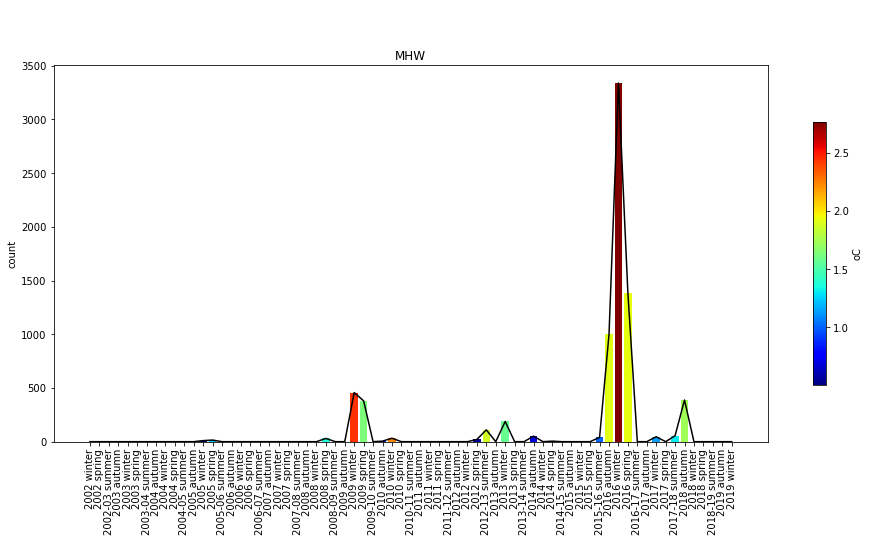

In [63]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
y = seasonDF4['count'].values
z1 = seasonDF4['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**Add the summary statistics into the 'data' as addiontal variables, so that we can display them 
as maps**

In [54]:
mhwDF4.set_index('pointID',inplace=True)

In [57]:
latSize = data.latitude.size
lonSize = data.longitude.size
noEventsA = mhwDF4['noEvents'].values.reshape(latSize,lonSize)
noDaysA = mhwDF4['noDays'].values.reshape(latSize,lonSize)
totalIntensityA = mhwDF4['totalIntensity'].values.reshape(latSize,lonSize)
overallIntensityA = mhwDF4['overallIntensity'].values.reshape(latSize,lonSize)
highestIntensityA = mhwDF4['highestIntensity'].values.reshape(latSize,lonSize)
date_start_HIA = mhwDF4['date_start_HI'].values.reshape(latSize,lonSize)
largestDurationA = mhwDF4['largestDuration'].values.reshape(latSize,lonSize)
date_start_LDA = mhwDF4['date_start_LD'].values.reshape(latSize,lonSize)
intensityLDA = mhwDF4['intensityLD'].values.reshape(latSize,lonSize)
largestMeanIntensityA = mhwDF4['largestMeanIntensity'].values.reshape(latSize,lonSize)
date_start_LMIA = mhwDF4['date_start_LMI'].values.reshape(latSize,lonSize)
duration_LMIA = mhwDF4['duration_LMI'].values.reshape(latSize,lonSize)
largestCumIntensityA = mhwDF4['largestCumIntensity'].values.reshape(latSize,lonSize)
date_start_LCIA = mhwDF4['date_start_LCI'].values.reshape(latSize,lonSize)
duration_LCIA = mhwDF4['duration_LCI'].values.reshape(latSize,lonSize)


In [58]:
data['noEvents'] = (('latitude','longitude'), noEventsA)
data['noDays'] = (('latitude','longitude'), noDaysA)
data['totalIntensity'] = (('latitude','longitude'), totalIntensityA)
data['overallIntensity'] = (('latitude','longitude'), overallIntensityA)
data['highestIntensity'] = (('latitude','longitude'), highestIntensityA)
data['date_start_HI'] = (('latitude','longitude'), date_start_HIA)
data['largestDuration'] = (('latitude','longitude'), largestDurationA)
data['date_start_LD'] = (('latitude','longitude'), date_start_LDA)
data['intensityLD'] = (('latitude','longitude'), intensityLDA)
data['largestMeanIntensity'] = (('latitude','longitude'), largestMeanIntensityA)
data['date_start_LMI'] = (('latitude','longitude'), date_start_LMIA)
data['duration_LMI'] = (('latitude','longitude'), duration_LMIA)
data['largestCumIntensity'] = (('latitude','longitude'), largestCumIntensityA)
data['date_start_LCI'] = (('latitude','longitude'), date_start_LCIA)
data['duration_LCI'] = (('latitude','longitude'), duration_LCIA)

In [59]:
data

<xarray.Dataset>
Dimensions:               (latitude: 64, longitude: 17, time: 5900)
Coordinates:
  * time                  (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude              (latitude) float64 -28.85 -28.95 ... -35.05 -35.15
  * longitude             (longitude) float64 158.3 158.4 158.5 ... 159.8 159.9
Data variables:
    sst                   (time, latitude, longitude) float32 nan nan ... 15.565
    noEvents              (latitude, longitude) int64 9 14 11 10 11 ... 7 5 5 6
    noDays                (latitude, longitude) int64 65 86 63 65 ... 37 32 34
    totalIntensity        (latitude, longitude) float64 28.02 43.13 ... 26.8
    overallIntensity      (latitude, longitude) float64 0.4311 0.5015 ... 0.7882
    highestIntensity      (latitude, longitude) float64 2.766 2.978 ... 1.924
    date_start_HI         (latitude, longitude) int64 -3910 -1404 ... 1134 1302
    largestDuration       (latitude, longitude) int64 11 9 7 15 16 

**Display the summary statistics as maps**

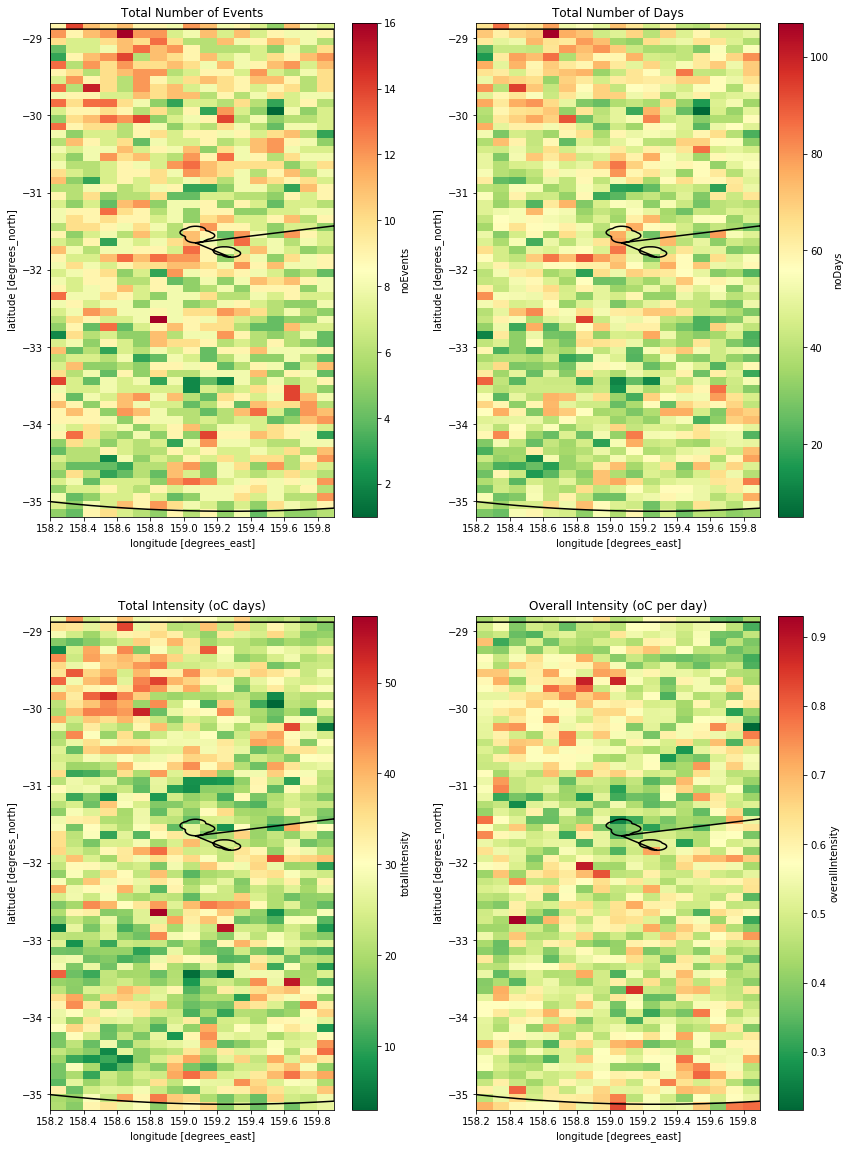

In [60]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.noEvents.plot(cmap='RdYlGn_r')
plt.title('Total Number of Events')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.noDays.plot(cmap='RdYlGn_r')
plt.title('Total Number of Days')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.totalIntensity.plot(cmap='RdYlGn_r')
plt.title('Total Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.overallIntensity.plot(cmap='RdYlGn_r')
plt.title('Overall Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()

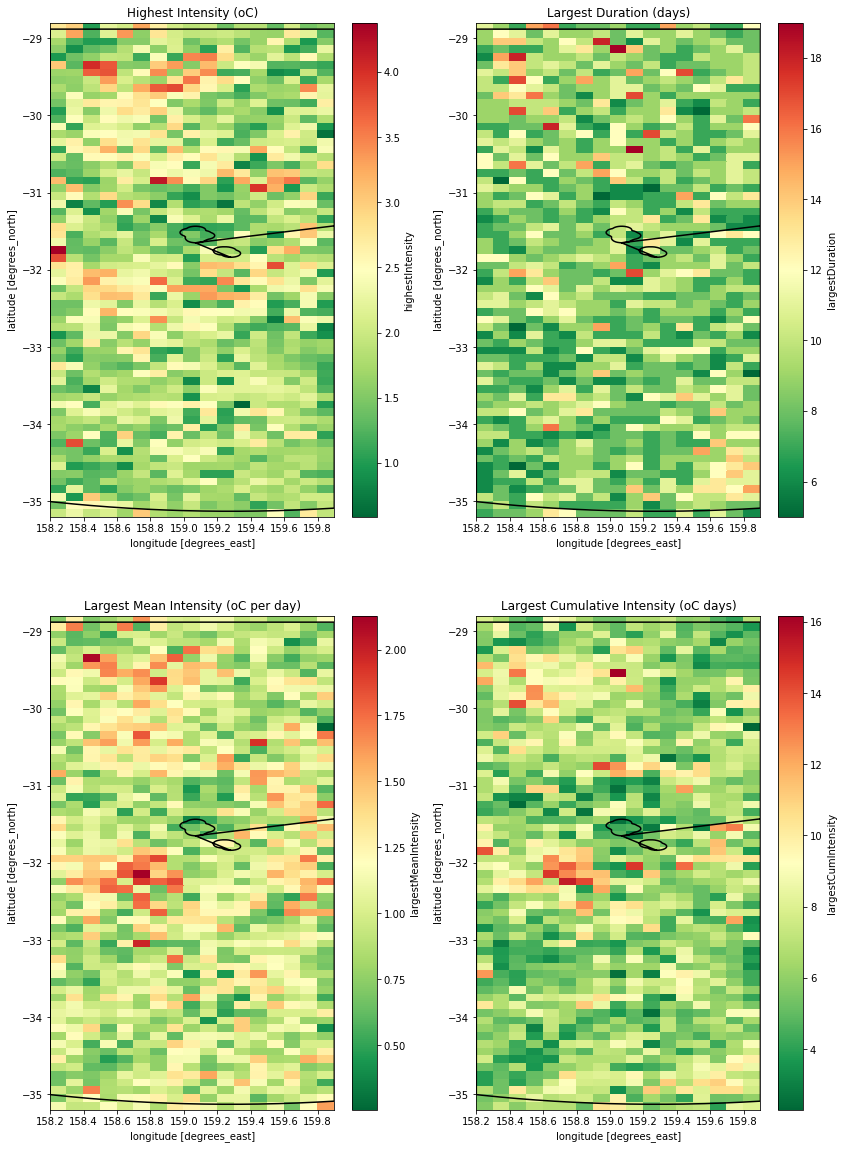

In [61]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.highestIntensity.plot(cmap='RdYlGn_r')
plt.title('Highest Intensity (oC)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.largestDuration.plot(cmap='RdYlGn_r')
plt.title('Largest Duration (days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.largestMeanIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Mean Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.largestCumIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Cumulative Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()
